# Preprocessing Script
- Ingest a MIDI File, and mathematically encode it for ingestion into a neural network


In [1]:
# Makes 2 sequences for LSTM model consumption
#     1. Note/Chord/Rest Sequence 
#     2. Duration Sequence 

In [26]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
import fractions
import decimal
import re
import seaborn as sns

from music21 import converter, corpus, instrument, midi, note, chord, pitch, musicxml

plt.rcParams["figure.figsize"] = (20,10)


In [3]:
# Base function that opens the midi file
def open_midi(path):
    mf = midi.MidiFile()
    mf.open(path)
    mf.read()
    mf.close()
    return midi.translate.midiFileToStream(mf)

# Reference function 
# TODO: Delete this thing later when you can rewrite it!!
def extract_notes(midi_part):
    notes = [] 
    for nt in midi_part.flat.notes:
        notes.append(nt)
    return notes


def get_offsets_durations(midi_part):
    parent_element = [] 
    ret = [] 
    offsets = []
    durations = [] 
    for nt in midi_part.flat.notes:
        offsets.append(nt.offset)
        durations.append(nt.duration.quarterLength)
    return offsets, durations


# Convert midi part to a numpy array
def build_track(midi_part):
    return None 

# Build a map of all notes and chords to a value in 
def build_note_tbl(midi_stream):
    
    tbl = {}
    count = 1
    
    tbl["REST"] = 0

    for part in midi_stream: 
        for nt in part.flat.notes:
            if (isinstance(nt, note.Note)):
                if (nt.pitch.nameWithOctave not in tbl):
                    tbl[nt.pitch.nameWithOctave] = count
                    count += 1 
            elif (isinstance(nt, chord.Chord)):
                chord_name = ""
                for i in nt.notes:
                    chord_name += i.pitch.nameWithOctave + " "
                chord_name = chord_name[0:len(chord_name)-1]
                if (chord_name not in tbl):
                    tbl[chord_name] = count
                    count += 1
    
    # tbl maps note/chord to int
    # inv_tbl maps int to note/chord 
    inv_tbl = {v: k for k, v in tbl.items()}
    
    return tbl, inv_tbl

# Coonvert the times from floats to fractions
def convert_to_frac(times):
    dur = [0 for i in range(len(times))]
    for i in range(len(times)):
        if not isinstance(times[i], float):
            val = times[i]
        else:
            val = fractions.Fraction(times[i])
        dur[i]= val
        
    return dur

# Get LCM of denominators
# vals is an array of fractions
def arr_lcm(vals): 
    arr = [0 for i in range(len(vals))]
    for i in range(len(vals)):
        arr[i] = vals[i].denominator 
    ans = np.lcm(arr[0], arr[1])
    for i in range(2,len(arr)):
        ans = np.lcm(ans, arr[i])
    return ans



In [4]:
midi_name = "Paco_de_Lucia_Entre_dos_Aguas.mid" 
track = open_midi(midi_name)

In [5]:
off, dur = get_offsets_durations(track[0])
off, dur = convert_to_frac(off), convert_to_frac(dur)


In [6]:
# Find out the smallest part of a bar we have to break this thing into
# Each quarter has to be broken into 'lcm' parts

lcm = arr_lcm(off)
off = list(map(lambda x : int(x*lcm), off))
dur = list(map(lambda x : int(x*lcm), dur))

In [7]:
tbl, inv_tbl = build_note_tbl(track)
note_objs = extract_notes(track[0])
notes = [0 for i in range(len(note_objs))]

for i in range(len(note_objs)):
    nt = note_objs[i]
    if (isinstance(nt, note.Note)):
        notes[i] = nt.pitch.nameWithOctave
    elif (isinstance(nt, chord.Chord)):
        chord_name = ""
        for a in nt.notes:
            chord_name += a.pitch.nameWithOctave + " "
        chord_name = chord_name[0:len(chord_name)-1]
        notes[i] = chord_name

note_fin = ['a' for i in range(len(note_objs))]


# Convert to note objects
for i in range(len(notes)):
    note_fin[i] = tbl[notes[i]]
    
notes = note_fin
del note_objs
del note_fin

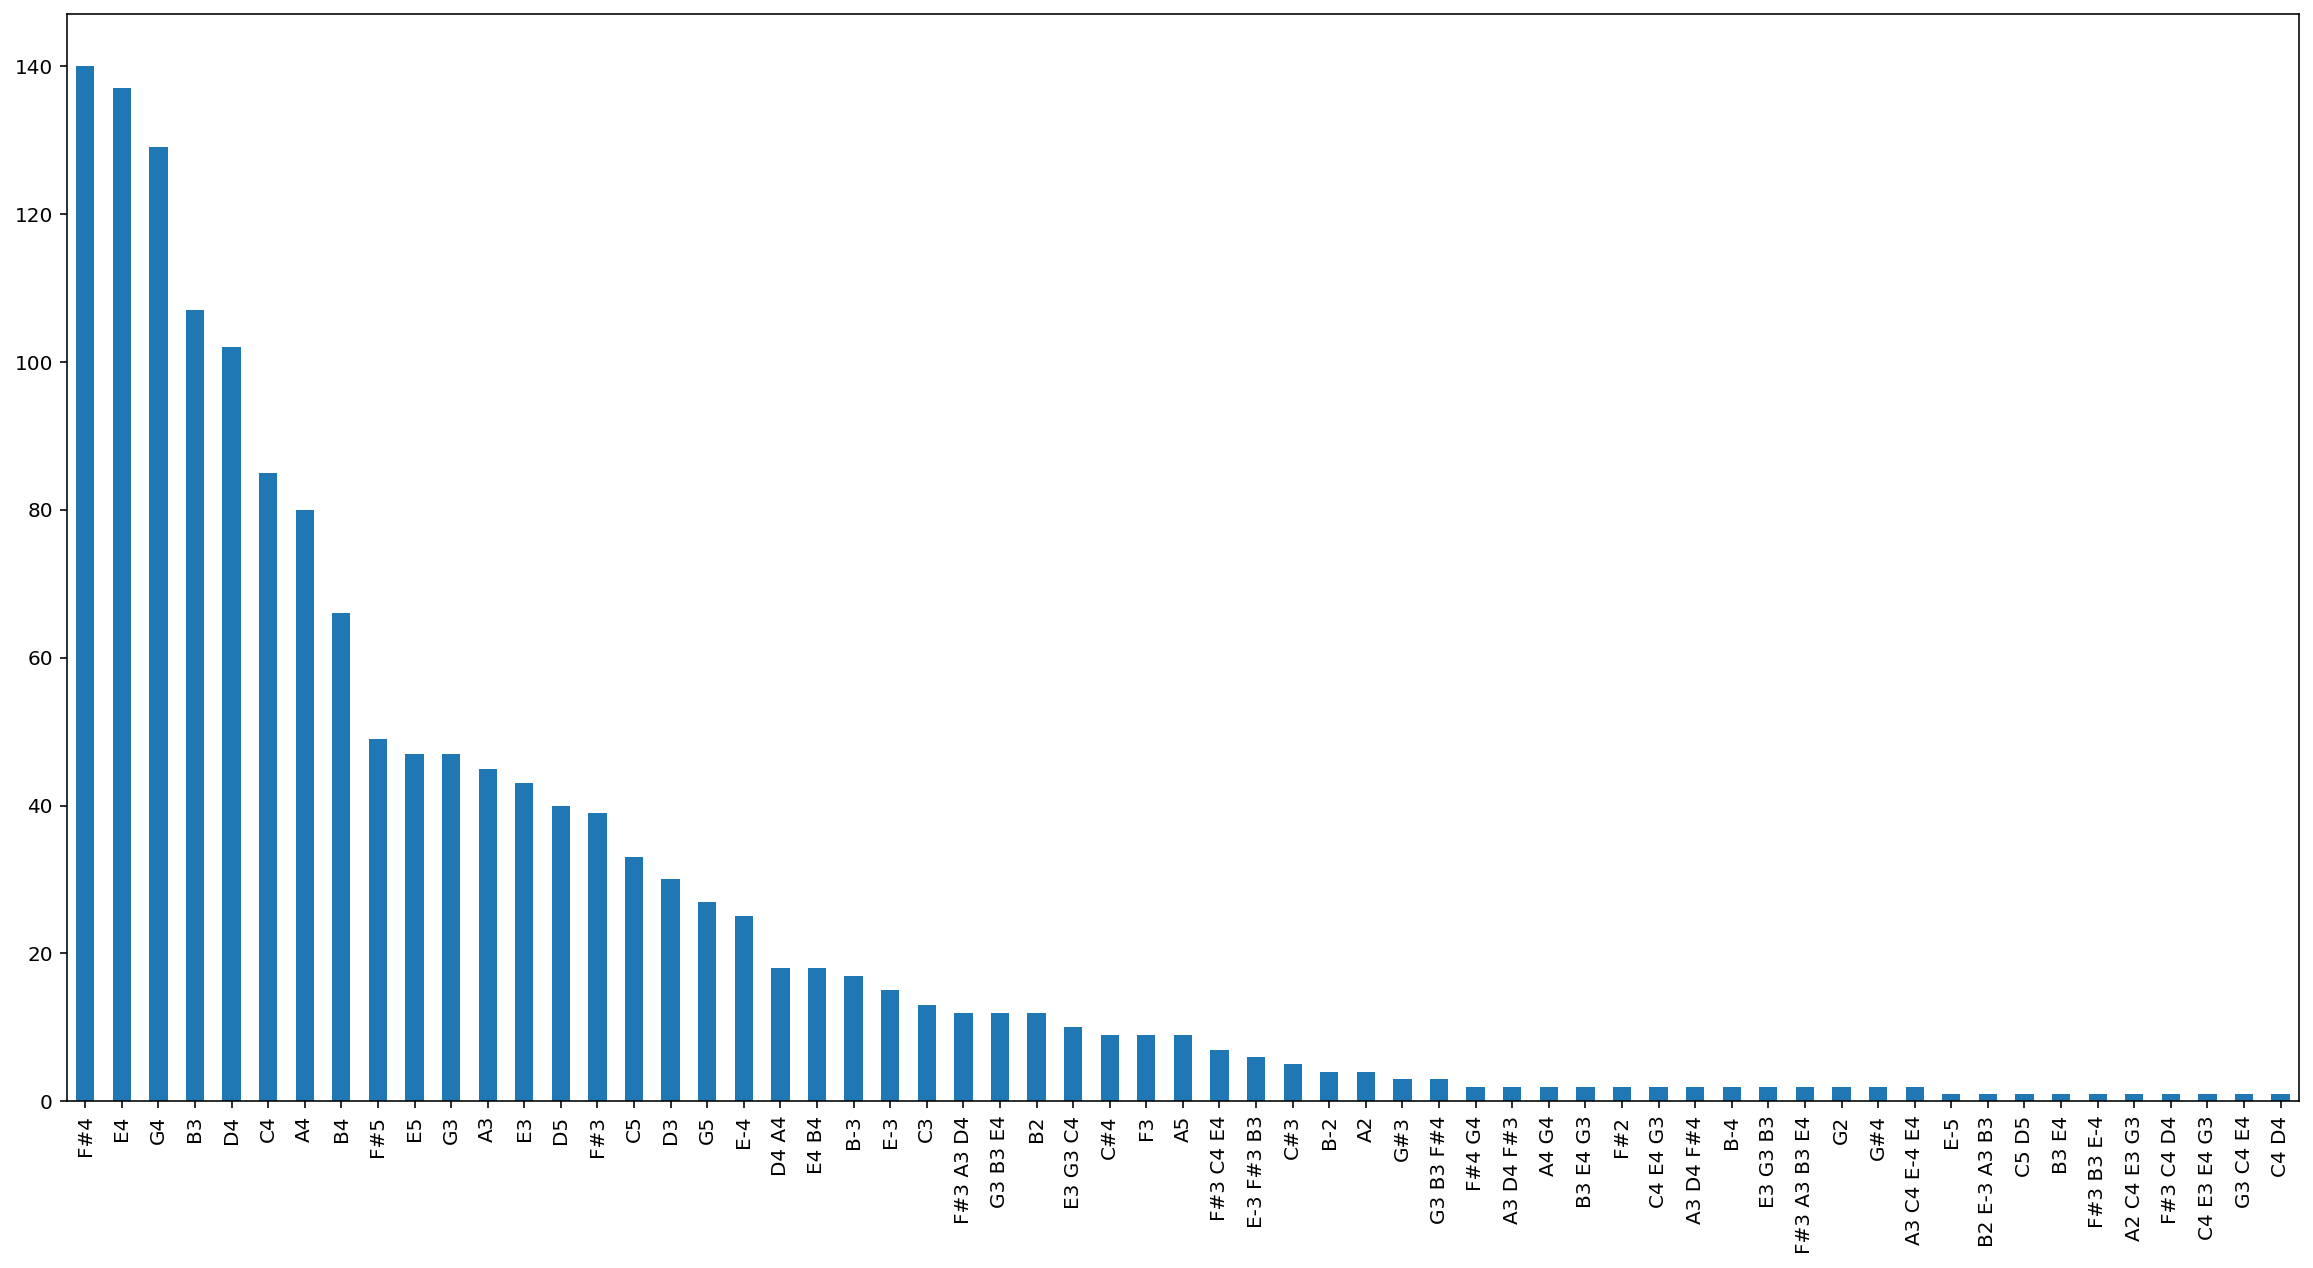

In [27]:
# Generate frequency plot of the notes in the song
note_names = [inv_tbl[notes[i]] for i in range(len(notes))]
pd.Series(note_names).value_counts().plot(kind='bar')
del note_names

In [9]:
# Final sequences to be ingested by the LSTM

note_seq = []
dur_seq = []
off_seq = []

tbl_max = max(inv_tbl.keys())
i = 0 

while (i < len(notes)):
    
    # if the start points of the notes are the same
    # merge them into a new chord
    
    off_seq.append(off[i])
    
    if (i != len(notes)-1) and (off[i+1] == off[i]):  
        new_dur = max(dur[i], dur[i+1])
        new_note = inv_tbl[notes[i]] + " " + inv_tbl[notes[i+1]]
        chord_name = new_note.split()
        chord_name.sort()
        new_note = ' '.join(chord_name)
        
        # Update the note tables with our new concantonated chord 
        if (new_note not in tbl):
            tbl[new_note] = tbl_max
            inv_tbl[tbl_max] = new_note
            tbl_max += 1
        
        note_seq.append(tbl[new_note])
        dur_seq.append(new_dur)
        i += 2
        
    else:
        note_seq.append(notes[i])
        dur_seq.append(dur[i])
        i += 1
        
del i 

In [10]:
notes = note_seq
off = off_seq
dur = dur_seq

In [19]:
accum = 0
final_notes = []
final_dur = []
final_off = [] 

for i in range(len(notes)):
    
    
    if (accum != off[i]):
        # insert a rest
        final_notes.append(0)
        final_dur.append(off[i] - accum)
        final_off.append(accum)
        accum = off[i]
    final_notes.append(notes[i])
    final_dur.append(dur[i])
    final_off.append(off[i])
    accum += dur[i]
            


In [29]:
encoded_part = pd.DataFrame({'Note': final_notes, 'Duration': final_dur, 'Offset': final_off})
# display(encoded_part)

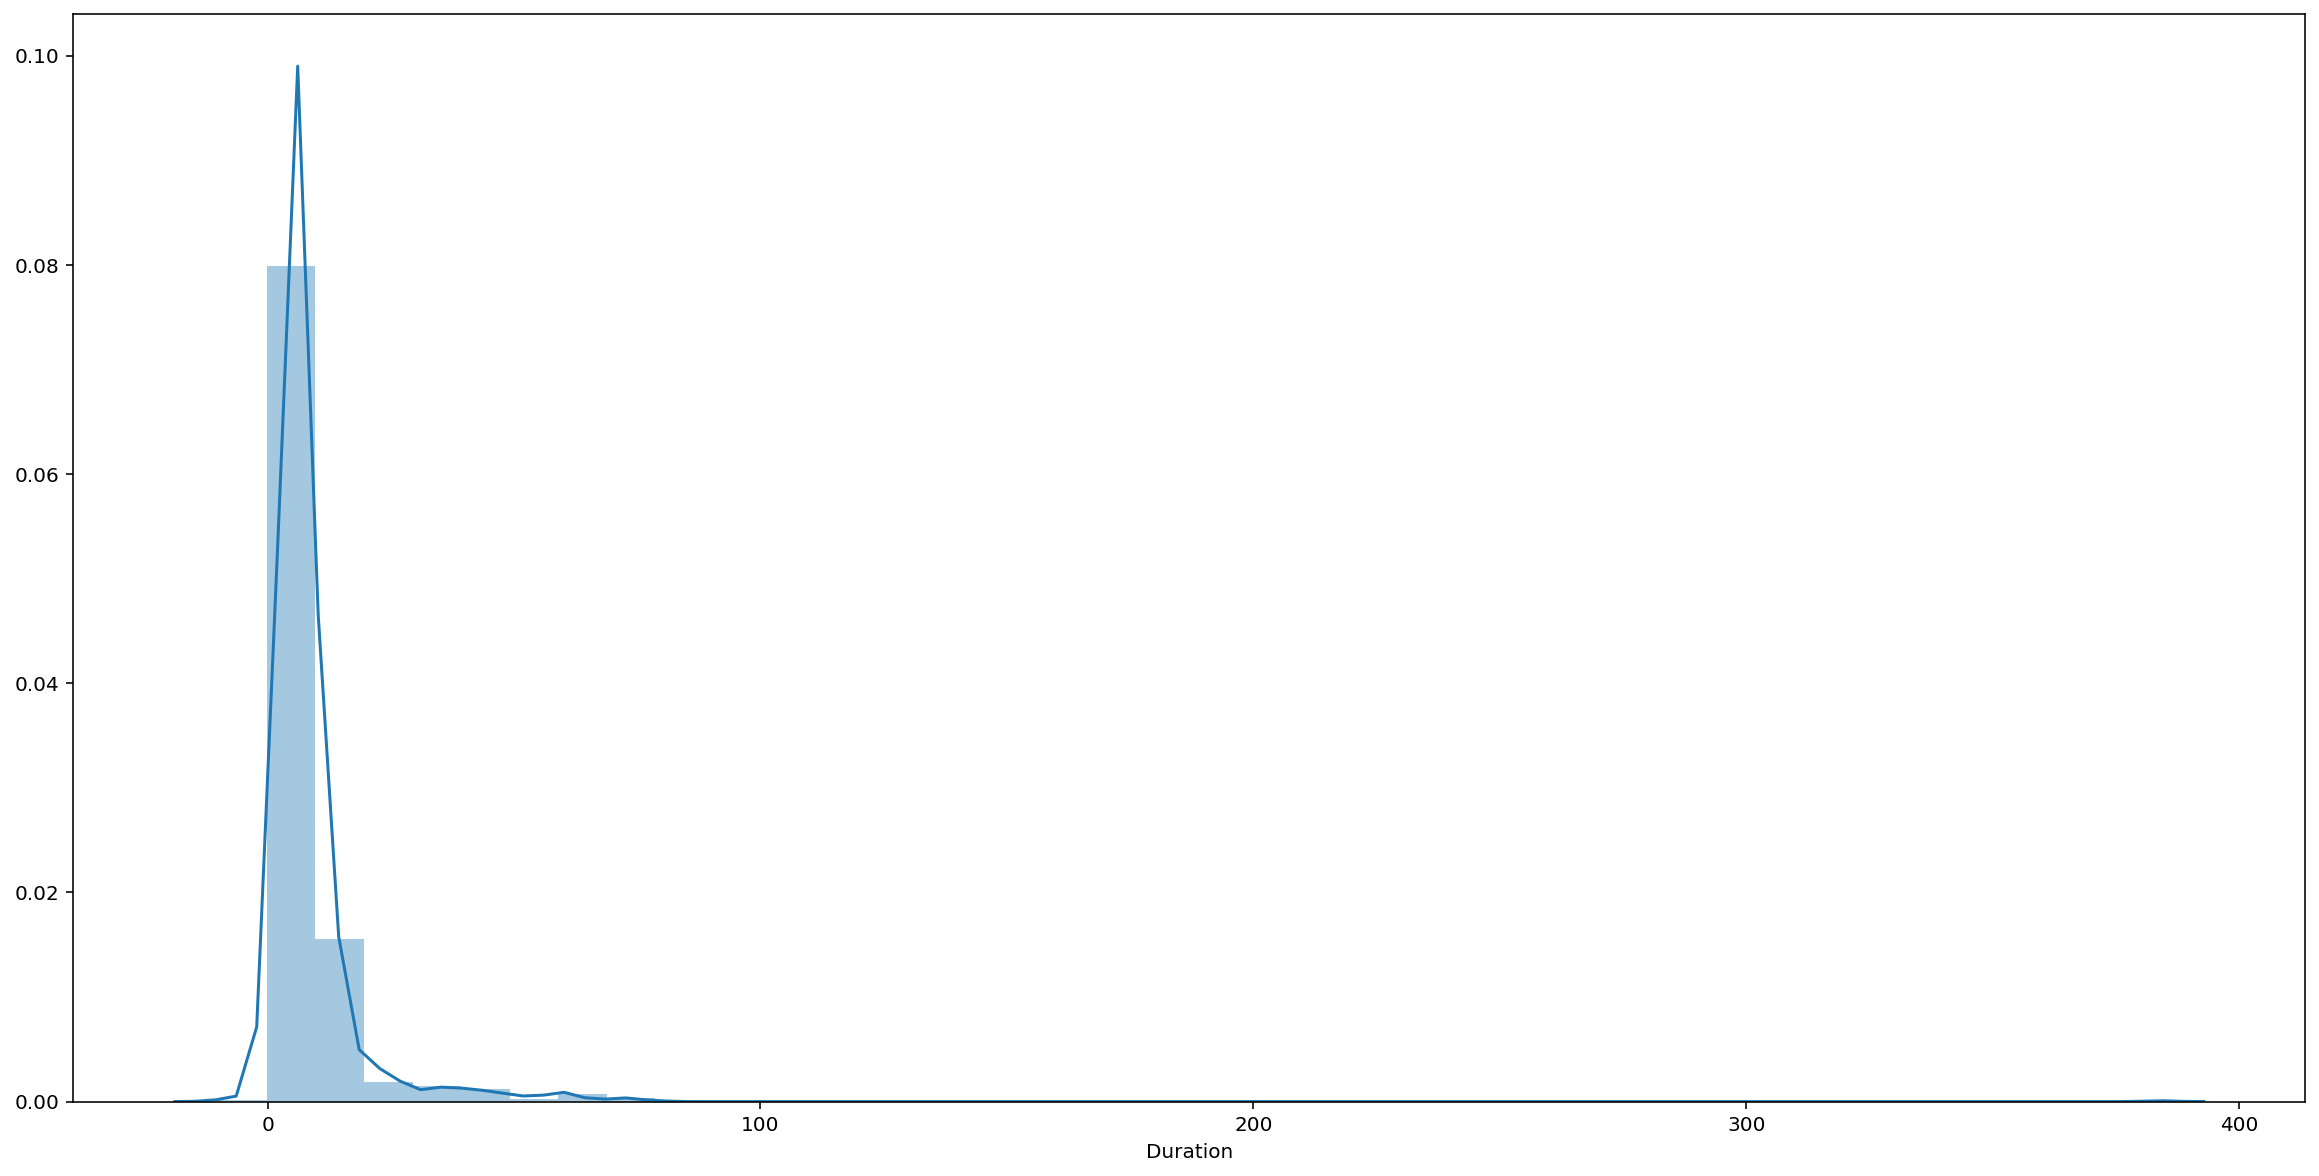

In [31]:
sns.distplot(encoded_part['Duration'])

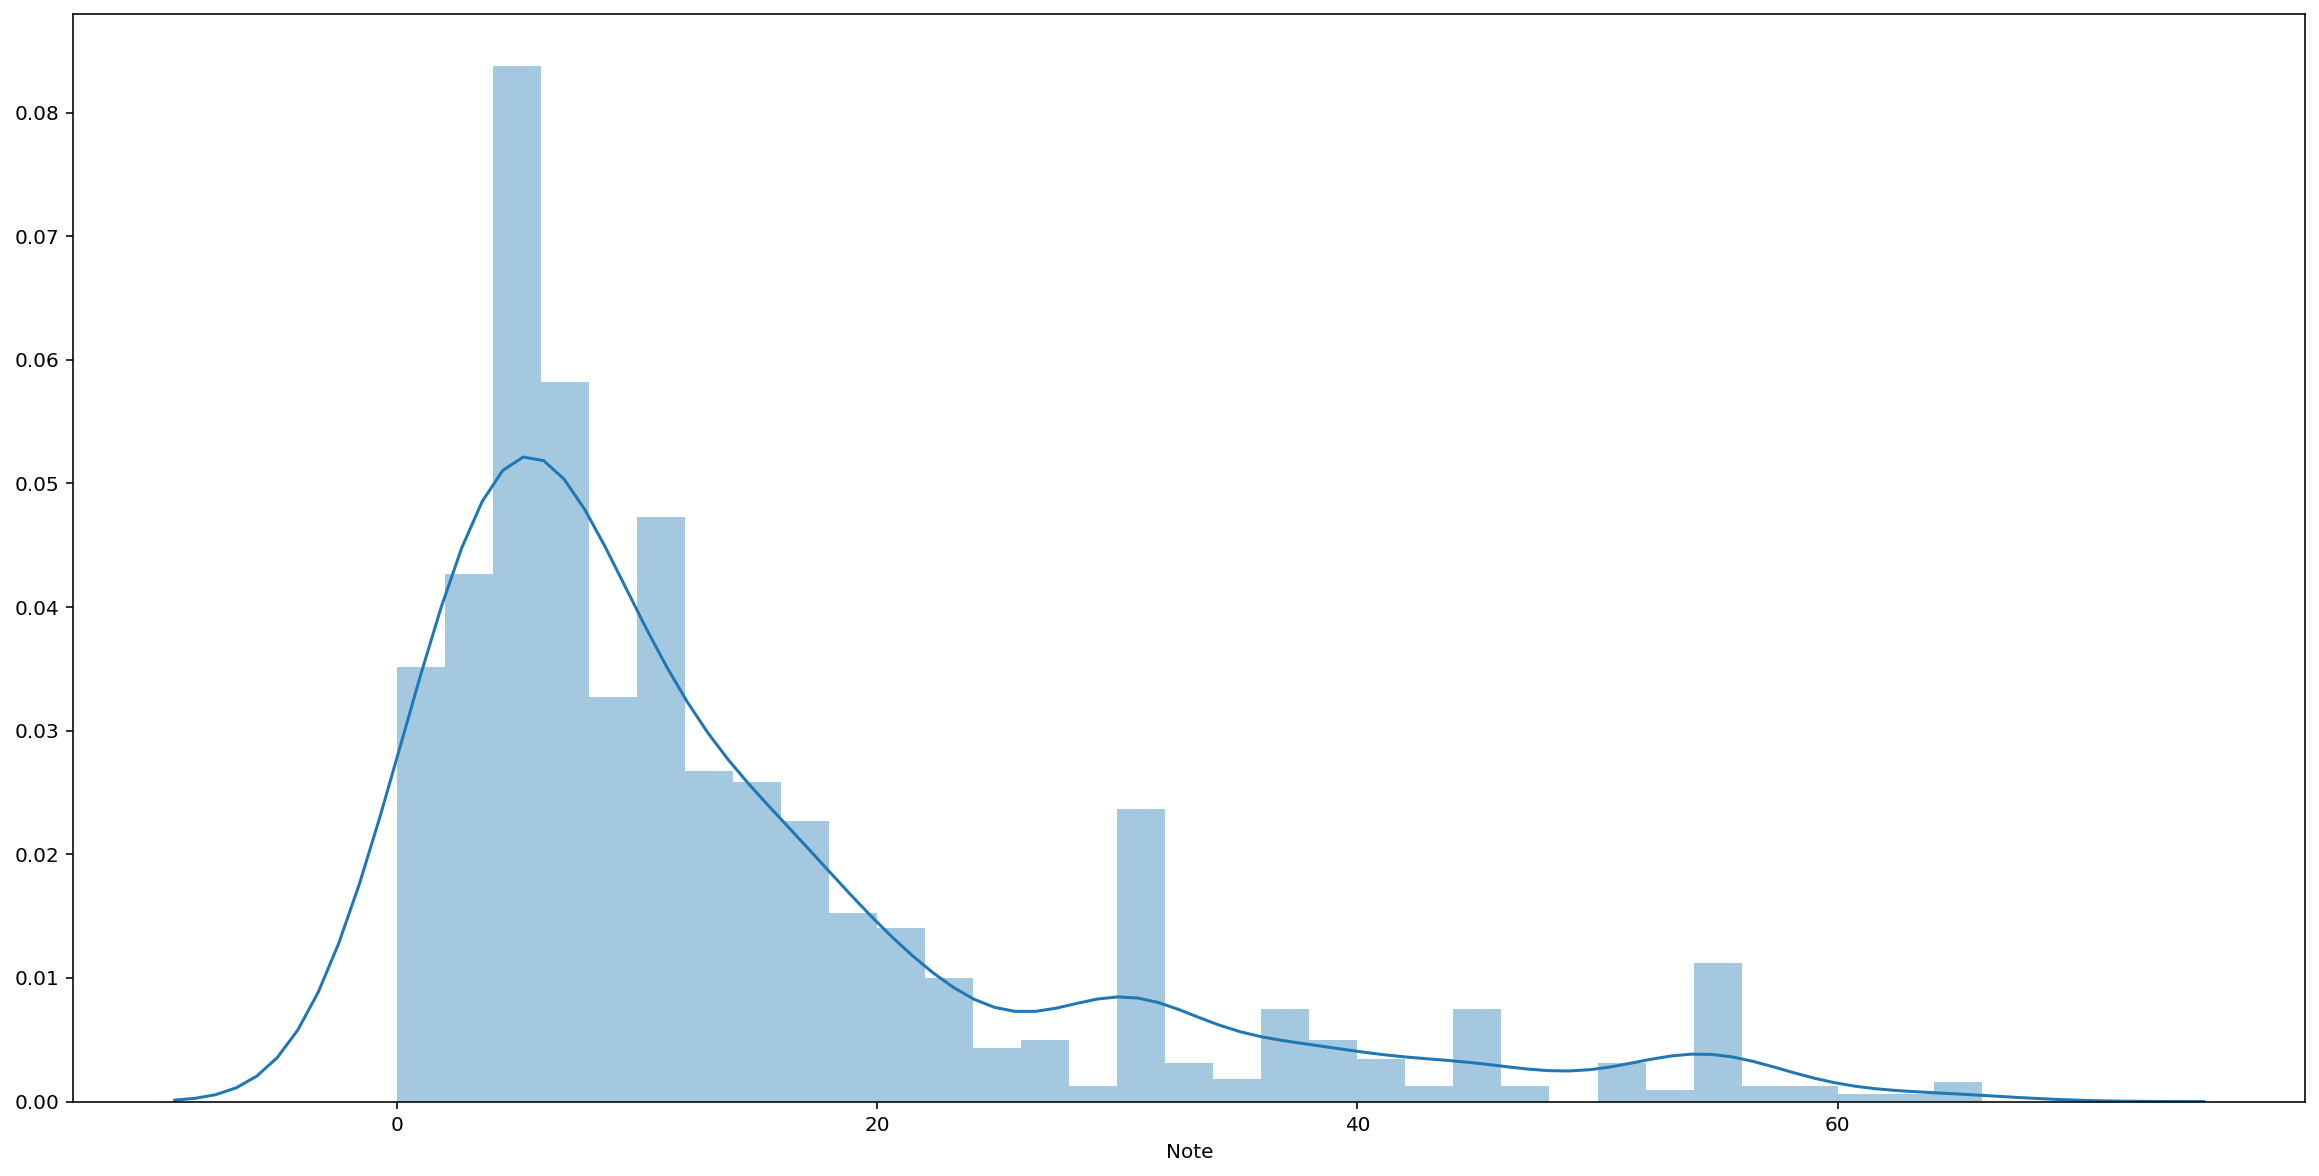

In [32]:
sns.distplot(encoded_part['Note'])